In [1]:
# Dependencies
import hvplot.pandas

import requests
import pandas as pd
from census import Census
import numpy as np
import matplotlib.pyplot as plt
from config import api_key
import seaborn as sns
import plotly.express as px
import geopandas as gpd



In [2]:
## Pulling Median Income By County (CA)

years = [2018,2019,2021,2022] # no 2020 data available due to COVID -19
med_income_var = 'B19013_001E'
base_url = 'https://api.census.gov/data/'
geo = '&for=county:*&in=state:06'  # California = 06
dfs = []

for year in years: 
    url = f'{base_url}{year}/acs/acs1?get={med_income_var}{geo}&key={api_key}'

    data = requests.get(url).json()

    data = pd.DataFrame(data[1:])
   
    data["Year"] = year

    data = data.rename(columns={0: 'Median Income',1: 'State',2:'County'})
    dfs.append(data)

income_data_county = pd.concat(dfs, ignore_index=True)
income_data_county['State'] = pd.to_numeric(income_data_county['State'])
income_data_county['County'] = pd.to_numeric(income_data_county['County'])
income_data_county["Median Income"] = income_data_county["Median Income"].astype('int')
income_data_county



,Median Income,State,County,Year
0,48554,6,33,2018
1,57745,6,47,2018
2,101618,6,13,2018
3,60321,6,99,2018
4,77472,6,83,2018
...,...,...,...,...
160,58884,6,103,2022
161,64722,6,107,2022
162,102569,6,111,2022
163,83875,6,113,2022


In [3]:
## Pulling Median Income By State (CA)

years = [2018,2019,2021,2022] # no 2020 data available due to COVID -19
med_income_var = 'B19013_001E'
base_url = 'https://api.census.gov/data/'
geo = '&for=state:06'  # California = 06
dfs = []

for year in years: 
    url = f'{base_url}{year}/acs/acs1?get={med_income_var}{geo}&key={api_key}'

    data = requests.get(url).json()

    data = pd.DataFrame(data[1:])
   
    data["Year"] = year

    data = data.rename(columns={0: 'Median Income',1: 'State',2:'County'})
    dfs.append(data)

income_data_state = pd.concat(dfs, ignore_index=True)
income_data_state['State'] = pd.to_numeric(income_data_state['State'])
income_data_state["Median Income"] = income_data_state["Median Income"].astype('int')
income_data_state

,Median Income,State,Year
0,75277,6,2018
1,80440,6,2019
2,84907,6,2021
3,91551,6,2022


In [4]:
#Pulling Geocodes for State(CA)
geocodes_csv = "../Josh/Resources/geocodes.csv"
geo_state = pd.read_csv(geocodes_csv)
geo_state = geo_state.rename(columns={"Area Name (including legal/statistical area description)":"Area","State Code (FIPS)":"State"})
geo_state = geo_state[(geo_state['State']== 6) & (geo_state["County Code (FIPS)"]==0) *(geo_state["Place Code (FIPS)"] == 0)]
geo_state = geo_state[["State","Area"]]
geo_state

,State,Area
1393,6,California


In [5]:
#Pulling Geocodes for County(CA)
geocodes_csv = "../Josh/Resources/geocodes.csv"
geo_county = pd.read_csv(geocodes_csv)
geo_county = geo_county.rename(columns={"Area Name (including legal/statistical area description)":"Area","State Code (FIPS)":"State","County Code (FIPS)":"County"})
geo_county = geo_county[['State','County','Area']]
geo_county = geo_county[(geo_county['State']== 6) & (geo_county["County"] > 0)]
geo_county.head()

,State,County,Area
1394,6,1,Alameda County
1395,6,3,Alpine County
1396,6,5,Amador County
1397,6,7,Butte County
1398,6,9,Calaveras County


In [6]:
#Created CSV for Regions in case we want to do Socal/NorCal Analysis
state_split_csv = "../Josh/Resources/California - Counties.csv"
state_split = pd.read_csv(state_split_csv)
state_split.head()

,County,Region
0,Alameda County,NorCal
1,Alpine County,NorCal
2,Amador County,NorCal
3,Butte County,NorCal
4,Calaveras County,NorCal


In [7]:
#Merging DF's for County Names
data_county = pd.merge(income_data_county,geo_county,on=['State','County'],how='left')
data_county.drop(columns=["County"], inplace=True)
data_county.rename(columns={'Area': 'County'},inplace=True)
data_county['State'] = 'California'
data_county  = pd.merge(data_county,state_split, on= "County",how='left')
data_county = data_county[['Year', 'State','Region','County','Median Income']]
data_county.head()


,Year,State,Region,County,Median Income
0,2018,California,NorCal,Lake County,48554
1,2018,California,NorCal,Merced County,57745
2,2018,California,NorCal,Contra Costa County,101618
3,2018,California,NorCal,Stanislaus County,60321
4,2018,California,SoCal,Santa Barbara County,77472


In [8]:
#Merging DF's for State Name (Can easily rename column to 'California' but merging will ensure accuracy of pull)
data_state = pd.merge(income_data_state,geo_state,on=['State'],how='left')
data_state.drop(columns=["State"],inplace=True)
data_state.rename(columns={"Area":"State"},inplace=True)
data_state = data_state[["Year","State","Median Income"]]
data_state

,Year,State,Median Income
0,2018,California,75277
1,2019,California,80440
2,2021,California,84907
3,2022,California,91551


In [9]:
#Working with Median Housing Price Data - Cleaning up and getting Mean by year

pd.set_option('display.float_format', '{:.2f}'.format)

csv = "../Josh/Resources/Median(New) - MedianPricesofExistingDetachedHomesHistoricalData.csv"

median_data = pd.read_csv(csv)

median_data = median_data.drop('Unnamed: 54',axis=1)
median_data = median_data.astype('str')

def clean_currency(value):
    try:
        return int(str(value).replace(',', '').replace('$', ''))
    except ValueError:
        # Return np.nan for non-convertible values
        return np.nan

columns_to_clean = ['CA', 'Alameda', 'Amador', 'Butte', 'Calaveras',
       'Contra-Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
       'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Nevada',
       'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus',
       'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo',
       'Yuba', 'Condo', 'LA Metro', 'Central Coast', 'Central Valley',
       'Far North', 'Inland Empire', 'S.F. Bay Area', 'SoCal']
median_data[columns_to_clean] = median_data[columns_to_clean].applymap(clean_currency)
median_data["Mon-Yr"] = pd.to_datetime(median_data["Mon-Yr"],format='%b-%y')
median_data = median_data[median_data["Mon-Yr"] >= "2018-01-01"]

median_data["Year"] = median_data["Mon-Yr"].dt.year
median_data = median_data[['Year', 'CA', 'Alameda', 'Amador', 'Butte', 'Calaveras',
       'Contra-Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
       'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Nevada',
       'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus',
       'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo',
       'Yuba']]
median_data.reset_index().drop(columns=["index"])
median_grp = median_data.groupby("Year")

median_data = median_grp.mean().reset_index()
median_data


/var/folders/76/fkb8cxfd6ll30th2nr0wvckc0000gn/T/ipykernel_23541/3437841457.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  median_data[columns_to_clean] = median_data[columns_to_clean].applymap(clean_currency)


,Year,CA,Alameda,Amador,Butte,Calaveras,Contra-Costa,Del Norte,El Dorado,Fresno,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
0,2018,571057.50,926358.33,327476.67,320112.50,321708.33,649169.17,230191.67,491687.42,268630.83,...,667375.00,312658.33,293766.67,219012.50,NaN,232981.67,295350.83,654005.83,439729.17,278813.33
1,2019,591865.83,911500.00,324687.50,361633.33,339101.67,661736.67,261485.83,497453.33,281920.83,...,655243.33,326854.17,310212.50,255875.00,258329.17,243641.67,301125.00,651220.83,452575.83,294937.50
2,2020,650156.67,1001271.67,346366.67,384780.83,366409.17,737000.00,290100.00,529164.17,309070.83,...,695219.17,359583.33,339108.33,276604.17,296495.83,267141.67,317875.00,714145.83,485400.83,333161.67
3,2021,785640.83,1242958.33,421805.83,434448.33,459687.50,902541.67,365845.83,646720.00,367208.33,...,767266.67,425541.67,399816.67,327787.50,327479.17,318210.00,380051.67,819937.50,575560.83,401433.33
4,2022,821204.17,1306546.67,418425.00,446898.33,473070.83,903200.00,375087.50,671083.33,408416.67,...,826887.50,455695.00,431525.00,327394.17,303500.00,357455.83,413500.83,886541.67,623743.33,428329.17
5,2023,811128.89,1221111.11,445243.33,427863.33,480388.89,853632.22,352388.89,653413.33,409376.67,...,831598.89,450738.89,414500.00,321958.89,316343.75,361255.56,407450.00,889444.44,601711.11,435237.78


In [10]:
#melt(take columns and make them rows) Housing Median Price DF into two DFS: One For CA and one by County.  
# Also merging with Median Income DF's 

melted_df = pd.melt(median_data, id_vars=['Year'], var_name='Region', value_name='Median Housing Price')
melted_df["Region"] = melted_df["Region"] + " County"
melted_df.loc[melted_df['Region'] == 'CA County', 'Region'] = 'California'

#create county DF(Housing Prices)
housing_county = melted_df[melted_df['Region']!= 'California'].copy()
housing_county.rename(columns={"Region":"County"},inplace=True)

#create state DF (Housing Prices)
housing_state = melted_df[(melted_df['Region']== 'California') & (melted_df['Year'] != 2020) & (melted_df["Year"] != 2023)].copy()

housing_state = housing_state.reset_index().drop(columns=['index'])
housing_state.rename(columns={"Region":"State"},inplace=True)
state_df = pd.merge(data_state,housing_state,on=["Year","State"])
county_df = pd.merge(data_county,housing_county,on=["Year","County","County"])



In [11]:
county_df.head()

,Year,State,Region,County,Median Income,Median Housing Price
0,2018,California,NorCal,Lake County,48554,269408.33
1,2018,California,NorCal,Merced County,57745,268086.67
2,2018,California,NorCal,Stanislaus County,60321,312658.33
3,2018,California,SoCal,Santa Barbara County,77472,662729.17
4,2018,California,NorCal,Sacramento County,69767,365454.17


In [12]:
state_df

,Year,State,Median Income,Median Housing Price
0,2018,California,75277,571057.50
1,2019,California,80440,591865.83
2,2021,California,84907,785640.83
3,2022,California,91551,821204.17


Text(0.5, 1.0, 'Median Income VS Median Housing Price (2018-2022 Data)')

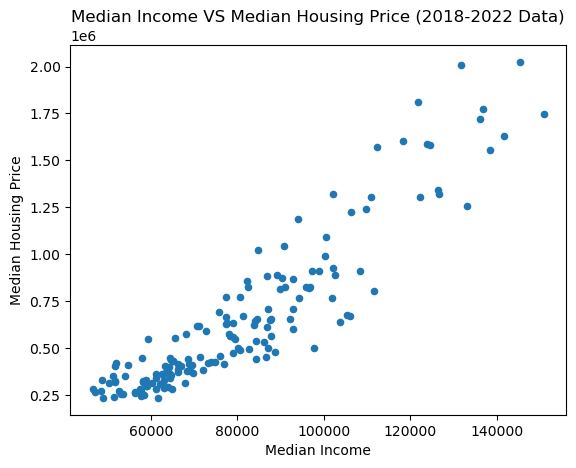

In [13]:
county_scatter = county_df.plot.scatter(x='Median Income', y='Median Housing Price', marker='o', linestyle='-')
plt.title("Median Income VS Median Housing Price (2018-2022 Data)")

<Axes: xlabel='Median Income', ylabel='Median Housing Price'>

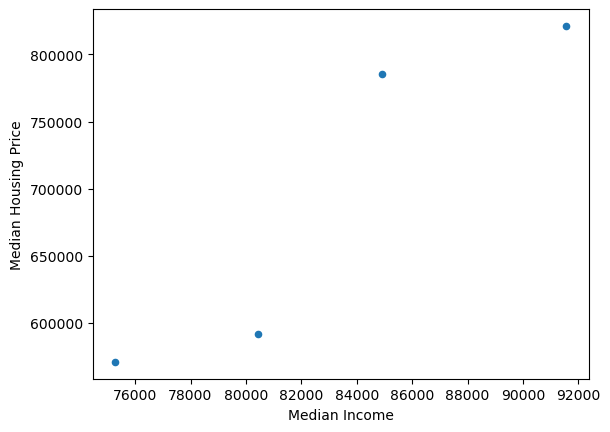

In [14]:
state_df.plot.scatter(x='Median Income', y='Median Housing Price', marker='o', linestyle='-')


Text(0.5, 1.0, 'Median Housing Income VS Year')

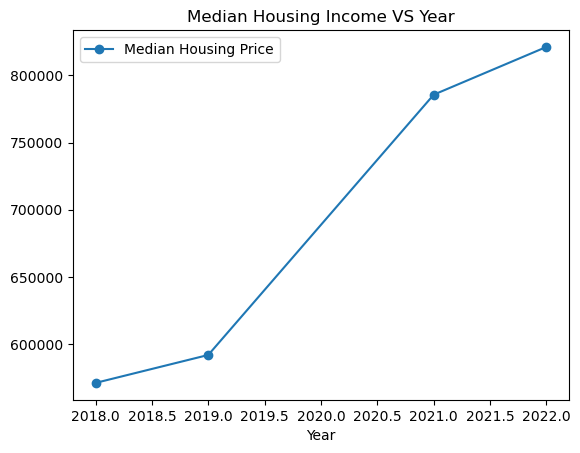

In [15]:
state_df.plot(x='Year', y='Median Housing Price', marker='o', linestyle='-')
plt.title("Median Housing Income VS Year")
#Having trouble cleaning this up for X axis using xticks. #Help? Lol 

In [16]:
heat_df_income_2018 = county_df[county_df['Year'] == 2018][['County','Median Income']]
heat_df_income_2018.set_index('County', inplace=True)

heat_df_housing_2018 = county_df[county_df['Year'] == 2018][['County','Median Housing Price']]


heat_df_income_2022 = county_df[county_df['Year'] == 2022][['County','Median Income']]
heat_df_income_2022.set_index('County', inplace=True)

heat_df_housing_2022 = county_df[county_df['Year'] == 2022][['County','Median Housing Price']]


df3_2018 = heat_df_housing_2018.rename(columns={'County': 'COUNTY_NAME'})
df3_2022 = heat_df_housing_2022.rename(columns={'County': 'COUNTY_NAME'})

In [22]:
california_counties_geojson = "../Josh/Resources/California_County_Boundaries.geojson"  # Replace with the actual path
gdf_counties = gpd.read_file(california_counties_geojson)

gdf_counties["County"] = " County"
gdf_counties["COUNTY_NAME"] = gdf_counties["COUNTY_NAME"] + gdf_counties["County"]
gdf_counties.drop(columns="County", inplace=True)






heatmap_data = df3_2022


df_heatmap = pd.DataFrame(heatmap_data)

gdf_counties_heatmap = pd.merge(gdf_counties, df_heatmap, on='COUNTY_NAME', how='left')
color_scale_range = [0,1000000]
fig = px.choropleth_mapbox(
    gdf_counties_heatmap,
    geojson=gdf_counties_heatmap.geometry,
    locations=gdf_counties_heatmap.index,
    color='Median Housing Price',
    hover_name='COUNTY_NAME',
    hover_data={'COUNTY_NAME': False, 'Median Housing Price': ':.2f'},
    color_continuous_scale="RdYlGn_r",
    range_color=color_scale_range,

    mapbox_style="carto-positron",
    center={"lat": 36.7783, "lon": -119.4179},  # Center of California
    zoom=4,
)

fig.update_layout(
    title_text="2022 Median Housing Prices",
    title_x=0.5)

fig.write_image("../Josh/Visuals/2023_heatmap_housing.png")



In [21]:


california_counties_geojson = "../Josh/Resources/California_County_Boundaries.geojson"  # Replace with the actual path
gdf_counties = gpd.read_file(california_counties_geojson)

gdf_counties["County"] = " County"
gdf_counties["COUNTY_NAME"] = gdf_counties["COUNTY_NAME"] + gdf_counties["County"]
gdf_counties.drop(columns="County", inplace=True)






heatmap_data = df3_2018


df_heatmap = pd.DataFrame(heatmap_data)

gdf_counties_heatmap = pd.merge(gdf_counties, df_heatmap, on='COUNTY_NAME', how='left')
color_scale_range = [0,1000000]

fig = px.choropleth_mapbox(
    gdf_counties_heatmap,
    geojson=gdf_counties_heatmap.geometry,
    locations=gdf_counties_heatmap.index,
    color='Median Housing Price',
    hover_name='COUNTY_NAME',
    hover_data={'COUNTY_NAME': False, 'Median Housing Price': ':.2f'},
    color_continuous_scale="RdYlGn_r",
    range_color=color_scale_range,
    mapbox_style="carto-positron",
    center={"lat": 36.7783, "lon": -119.4179},  # Center of California
    zoom=4,
)
fig.update_layout(
    title_text="2018 Median Housing Prices",
    title_x=0.5)

fig.write_image("../Josh/Visuals/2018_heatmap_housing.png")


